## Setup

### Installing Dependencies

In [1]:
# Data Loading
from datasets import load_dataset

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

# Transformers for Loading Base Model
from transformers import AutoTokenizer, AutoModelForCausalLM

# Mathematical libraries
import numpy as np
import math

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import pickle

# Utitlties
from collections import Counter
from functools import partial

### Fixing Random Seed for Reproducibility

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Creating Project Directory

In [3]:
proj_dir = "QLens/" # Personalize if needed
os.makedirs(proj_dir, exist_ok=True)

## Loading Pre-Trained One Transformer Block Tiny Stories Model

In [4]:
# Loading the model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1Layer-21M")
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1Layer-21M")

In [5]:
# Adding pad token to assist with batching later
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = '[PAD]'

# Resizing token embeddings accordingly
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 1024)

## Dataset Preparation

In [6]:
# Loading dataset
ds = load_dataset("roneneldan/TinyStories")

In [7]:
# Obtaining a sample of the original dataset to base further analysis on
ds_short = ds['validation']['text']

In [8]:
# Tokenizing
tokenized_ds_short = [tokenizer(text, return_tensors='pt') for text in ds_short]

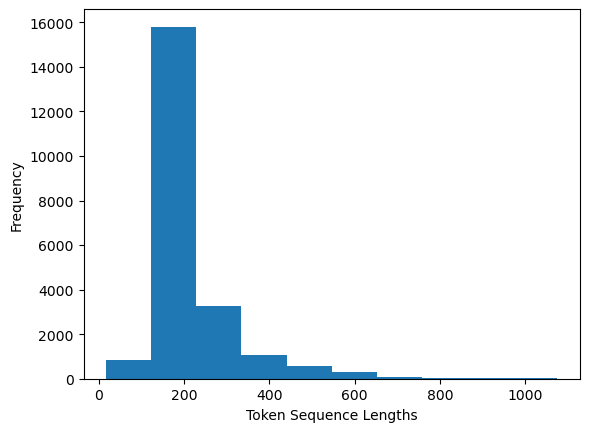

In [9]:
# Creating a plot of dataset sequence lengths
lengths = [text['input_ids'].shape[1] for text in tokenized_ds_short]

plt.hist(lengths, bins = 10)
plt.xlabel('Token Sequence Lengths')
plt.ylabel('Frequency')

plt.show()

In [10]:
# Slicing dataset instances as part of preparation for training

tokenized_inputs = []
for i in range(len(tokenized_ds_short)):
    toks = tokenized_ds_short[i]['input_ids']
    mask = tokenized_ds_short[i]['attention_mask']

    cut_idx = 0
    while cut_idx == 0:
        # Repeating until each input sequence has at least one token
        cut_idx = round(np.random.rand() * toks.shape[1])

    cut_inputs = {'input_ids': toks[:, :cut_idx],
                  'attention_mask': mask[:, :cut_idx]}

    tokenized_inputs.append(cut_inputs)

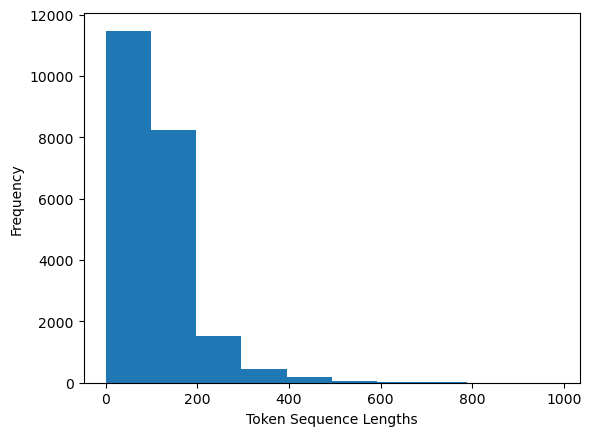

In [11]:
# Creating plot of dataset instance lengths after slicing
cut_lengths = [text['input_ids'].shape[1] for text in tokenized_inputs]

plt.hist(cut_lengths, bins = 10)
plt.xlabel('Token Sequence Lengths')
plt.ylabel('Frequency')

plt.show()

In [24]:
# Saving sliced inputs
with open(f'{proj_dir}tokenized_inputs.pkl', 'wb') as f:
    pickle.dump(tokenized_inputs, f)

### Dataset Class and Instances

In [12]:
class StoriesDataset(Dataset):
    def __init__(self, tokenized_inputs):
        # tokenized_inputs is a list of input token ids and attention masks
        self.tokenized_inputs = tokenized_inputs

    def __len__(self):
        return len(self.tokenized_inputs)

    def __getitem__(self, idx):
        return self.tokenized_inputs[idx]

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of dict with input_ids and attention_mask): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch):
    decoded_seqs = []

    for tok_seq in batch:
        text = tokenizer.decode(*tok_seq['input_ids'])
        decoded_seqs.append(text)

    padded = tokenizer(decoded_seqs, return_tensors = 'pt', padding = True)

    return padded

In [13]:
train_test_ratio = 0.75
cutoff = int(train_test_ratio * len(tokenized_inputs))

train_inputs = tokenized_inputs[:cutoff]
test_inputs = tokenized_inputs[cutoff:]

In [14]:
train_set = StoriesDataset(train_inputs)
test_set = StoriesDataset(test_inputs)

## Tuned Lens Preparation

### Submodel and Tuned Lens Classes

In [15]:
class AttentionModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.embeddings = original_model.transformer.wte
        self.position_embeddings = original_model.transformer.wpe
        self.ln_1 = original_model.transformer.h[0].ln_1
        self.attention = original_model.transformer.h[0].attn

    def forward(self, input_ids, key_padding_mask):
        # Getting token + position embeddings
        pos_ids = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        embedding_out = self.embeddings(input_ids) + self.position_embeddings(pos_ids)
        normalized_embeds = self.ln_1(embedding_out)

        # Pass through the first attention layer, casual mask is implemented internally
        atten_out = self.attention(normalized_embeds, attention_mask = key_padding_mask.unsqueeze(1).unsqueeze(2))[0] # returns (hidden_states, attn_weights)
        hidden_states = embedding_out + atten_out

        return hidden_states

class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.embeddings = original_model.transformer.wte
        self.position_embeddings = original_model.transformer.wpe

    def forward(self, input_ids, use_pos_embeds = True):

        if use_pos_embeds:
            # Preparing position IDs if needed
            pos_ids = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
            embedding_out = self.embeddings(input_ids) + self.position_embeddings(pos_ids)
        else:
            embedding_out = self.embeddings(input_ids)

        return embedding_out

In [16]:
class TunedLens(nn.Module):
    def __init__(self, d_model, last_norm, unembedding_layer, name, bias_only = True):
        super(TunedLens, self).__init__()
        self.bias = nn.Parameter(torch.zeros(d_model))  # shape (d_model,)
        self.layer_norm = last_norm
        self.unembedding = unembedding_layer
        self.name = name

        self.bias_only = bias_only
        # If not a bias only, a learnable weight matrix is also needed
        if not bias_only:
            self.weight_mat = nn.Parameter(torch.zeros(d_model, d_model))

        # freezing layer_norm and unembedding
        for param in self.layer_norm.parameters():
            param.requires_grad = False
        for param in self.unembedding.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: (B, S, d_model)
        adds bias and returns logits: (B, S, V)
        broadcasting of bias over batch and seq dims works via PyTorch broadcasting
        """

        if self.bias_only:
            z = x + self.bias  # broadcasts over last dim
        else:
            z = (x @ self.weight_mat) + self.bias

        z = self.layer_norm(z)
        logits = self.unembedding(z)  # (B, S, vocab_size)

        return logits

    def train_model(self,
                    train_dataloader,
                    criterion,
                    optimizer,
                    num_epochs,
                    device,
                    proj_dir,
                    sub_model,
                    final_model,
                    pad_token_id,
                    scheduler=None):
        """
        Trains the TunedLens.

        - train_dataloader yields batches of token ids -> shape (B, S)
        - sub_model and final_model are passed in and used in eval mode under no_grad()
        - scheduler may be per-batch (e.g., OneCycleLR) or per-epoch; this function
          automatically handles both. It prints the LR after each epoch.
        """
        self.to(device)
        train_losses = []

        # detect per-batch scheduler (OneCycleLR or _get_lr_called_within_step)
        per_batch_scheduler = scheduler is not None and hasattr(scheduler, "step") and getattr(scheduler, "_step_count", None) is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)

        # ensure teacher models are on device and in eval
        sub_model.to(device)
        final_model.to(device)
        sub_model.eval()
        final_model.eval()

        if isinstance(sub_model, EmbeddingModel):
            sub_model_type = 'embedding'
        else:
            sub_model_type = 'attention'

        print("Starting TunedLens training loop...")

        for epoch in range(1, num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0

            for batch_inputs in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
                # batch_tokens: LongTensor (B, S) on CPU or pinned memory; move to device
                batch_tokens = batch_inputs['input_ids'].to(device)
                batch_mask = batch_inputs['attention_mask'].to(device)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                input_mask = torch.zeros([batch_mask.shape[0], batch_mask.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    L = int(lengths[i].item())
                    input_tokens[i, :] = torch.cat((batch_tokens[i, : L - 1], batch_tokens[i, L:]))
                    input_mask[i, :] = torch.cat((batch_mask[i, :L - 1], batch_mask[i, L:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment
                input_mask = input_mask.to(torch.long)

                # compute mask of non-pad tokens (True = valid)
                loss_pad_mask = (input_tokens != pad_token_id)  # (B, S)

                # compute teacher signals in no_grad
                with torch.no_grad():
                    if sub_model_type == 'embedding':
                        residual = sub_model(input_tokens) # shape: (B, S, d_model)
                    else:
                        residual = sub_model(input_tokens, input_mask)

                    final_logits = final_model(input_ids = input_tokens, attention_mask = input_mask)['logits'] # shape: (B, S, vocab)

                # forward lens (student)
                student_logits = self(residual)  # (B, S, vocab)

                # compute masked KL loss
                loss = criterion(final_logits.float(), student_logits, pad_mask=loss_pad_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if scheduler is per-batch (e.g., OneCycleLR) step every batch
                if scheduler is not None and per_batch_scheduler:
                    scheduler.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_epoch_loss = epoch_loss / max(1, n_batches)
            train_losses.append(avg_epoch_loss)

            # step epoch-based schedulers here
            if scheduler is not None and not per_batch_scheduler:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers require a metric; we do not call those automatically
                    pass

            # print learning rate
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            print(f"Epoch [{epoch}/{num_epochs}]  Avg Loss: {avg_epoch_loss:.6f}  LR: {current_lr:.6g}")

            # optional: small quick eval on train subset or val set can be triggered here

        # Save checkpoint
        checkpoint = {
            'epoch': num_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + self.name + '_lens_checkpoint.pth')
        print(f"Checkpoint for Epoch {num_epochs} saved to {proj_dir + self.name + '_lens_checkpoint.pth'}")

        # Plot loss curve
        plt.figure()
        plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Lens Loss")
        plt.savefig(proj_dir + self.name + "_lens_training_loss.png")
        plt.show()

        return train_losses

    def evaluate_model(self, test_dataloader, criterion, device, sub_model=None, final_model=None, pad_token_id=None):
        """
        Evaluate the TunedLens on batched test data.

        Returns avg loss and accuracy (agreement with teacher's top prediction).
        """
        self.to(device)
        self.eval()
        if sub_model is not None:
            sub_model.to(device)
            sub_model.eval()
        if final_model is not None:
            final_model.to(device)
            final_model.eval()

        total_loss = 0.0
        total_valid = 0
        total_matches = 0

        if isinstance(sub_model, EmbeddingModel):
            sub_model_type = 'embedding'
        else:
            sub_model_type = 'attention'

        with torch.no_grad():
            for batch_inputs in tqdm(test_dataloader, desc=f"Eval {self.name} lens"):
                batch_tokens = batch_inputs['input_ids'].to(device) # (B, S)
                batch_mask = batch_inputs['attention_mask'].to(device) # (B, S)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                input_mask = torch.zeros([batch_mask.shape[0], batch_mask.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    L = int(lengths[i].item())
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :L - 1], batch_tokens[i, L:]))
                    input_mask[i, :] = torch.cat((batch_mask[i, :L - 1], batch_mask[i, L:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment
                input_mask = input_mask.to(torch.long)

                loss_pad_mask = (input_tokens != pad_token_id)

                # Obtaining residual from submodel
                if sub_model_type == 'embedding':
                    residual = sub_model(input_tokens) # shape: (B, S, d_model)
                else:
                    residual = sub_model(input_tokens, input_mask)

                teacher_logits = final_model(input_ids = input_tokens, attention_mask = input_mask)['logits'] # (B, S, V)
                student_logits = self(residual) # (B, S, V)

                # compute loss
                batch_loss = criterion(teacher_logits.float(), student_logits, pad_mask=loss_pad_mask)
                total_loss += batch_loss.item() * batch_tokens.size(0)  # weight by batch-size for averaging

                # Teacher logits for last valid position
                teacher_last = torch.zeros([teacher_logits.shape[0], 1, teacher_logits.shape[2]]).to(device)
                for i in range(teacher_logits.shape[0]):
                    L = int(lengths[i].item())
                    teacher_last[i, :, :] = teacher_logits[i, L - 2, :]
                teacher_last = teacher_last.squeeze(1)

                # Student logits for last valid position
                student_last = torch.zeros([student_logits.shape[0], 1, student_logits.shape[2]]).to(device)
                for i in range(student_logits.shape[0]):
                    L = int(lengths[i].item())
                    student_last[i, :, :] = student_logits[i, L - 2, :]
                student_last = student_last.squeeze(1)

                # Computing accuracy of top-1 on last position against teacher's top-1
                teacher_last_tok = teacher_last.argmax(dim=-1) # (B,)
                student_last_tok = student_last.argmax(dim=-1) # (B,)

                total_matches += (teacher_last_tok == student_last_tok).sum().item()
                total_valid += batch_tokens.size(0)

        avg_loss = total_loss / max(1, total_valid)
        accuracy = total_matches / max(1, total_valid)

        print(f"\nEval {self.name} Lens - Avg loss: {avg_loss:.6f}, Accuracy vs teacher (last pos): {accuracy:.4f}")
        return {"avg_val_loss": avg_loss, "accuracy": accuracy}

In [17]:
"""
kl_loss() computes the Kullback-Leibler (KL) divergence loss between
two sets of logits in accordance with the original Tuned Lens paper.

Args:
    base_logits (torch.Tensor): The logits from the base Transformer.
    lens_logits (torch.Tensor): The logits from the Tuned Lens model.

Returns:
    torch.Tensor: The mean KL divergence loss over the batch.
"""
def kl_loss_teacher_student(teacher_logits, student_logits, pad_mask=None):
    """
    Mask-aware KL divergence averaged over valid tokens.
    teacher_logits, student_logits: (B, S, V)
    pad_mask: (B, S) boolean where True = valid token; if None, all tokens valid.
    Returns scalar: mean KL over valid tokens.
    """
    # compute log-probabilities
    log_p = nn.functional.log_softmax(teacher_logits, dim=-1)   # log P (teacher)
    log_q = nn.functional.log_softmax(student_logits, dim=-1)   # log Q (student)
    p = torch.exp(log_p)  # P

    # per-token KL: sum over vocab dimension -> shape (B, S)
    per_token_kl = torch.sum(p * (log_p - log_q), dim=-1)

    if pad_mask is None:
        return per_token_kl.mean()
    else:
        # mask: True where valid
        mask = pad_mask.to(per_token_kl.device).float()
        total_valid = mask.sum()
        if total_valid.item() == 0:
            # no valid tokens: avoid divide-by-zero
            return torch.tensor(0.0, device=per_token_kl.device, requires_grad=True)
        masked_sum = (per_token_kl * mask).sum()
        return masked_sum / total_valid

### Embedding Lens

In [18]:
## Preparing for training the embedding lens

# Clearing cache to prepare for training
torch.cuda.empty_cache()

# Hyperparameters
batch_size = 4
num_epochs = 10

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
pad_idx = tokenizer.pad_token_id
d_model = model.transformer.wte.weight.shape[1]

# Embedding model
embedding_model = EmbeddingModel(model).to(device)

# DataLoaders that returns batches of token ids
embedding_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=2, pin_memory=True)

embedding_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn,
                         num_workers=2, pin_memory=True)

# Instantiating embedding lens
embedding_lens = TunedLens(d_model = d_model,
                           last_norm = model.transformer.ln_f,
                           unembedding_layer = model.lm_head,
                           name='embedding',
                           bias_only = False).to(device)

# optimizer & scheduler
embedding_lens_optimizer = optim.Adam(embedding_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch based LR)
embedding_lens_scheduler = OneCycleLR(embedding_lens_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(embedding_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/10: 100%|██████████| 4123/4123 [02:06<00:00, 32.56it/s]


Epoch [1/10]  Avg Loss: 2.131469  LR: 0.00280035


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2/10: 100%|██████████| 4123/4123 [02:06<00:00, 32.48it/s]


Epoch [2/10]  Avg Loss: 1.961561  LR: 0.0076007


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 3/10: 100%|██████████| 4123/4123 [02:07<00:00, 32.45it/s]


Epoch [3/10]  Avg Loss: 1.931313  LR: 0.01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 4/10: 100%|██████████| 4123/4123 [02:06<00:00, 32.54it/s]


Epoch [4/10]  Avg Loss: 1.897839  LR: 0.00950461


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 5/10: 100%|██████████| 4123/4123 [02:06<00:00, 32.55it/s]


Epoch [5/10]  Avg Loss: 1.874039  LR: 0.00811703


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 6/10: 100%|██████████| 4123/4123 [02:07<00:00, 32.46it/s]


Epoch [6/10]  Avg Loss: 1.854511  LR: 0.00611209


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 7/10: 100%|██████████| 4123/4123 [02:07<00:00, 32.45it/s]


Epoch [7/10]  Avg Loss: 1.836602  LR: 0.00388689


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 8/10: 100%|██████████| 4123/4123 [02:07<00:00, 32.42it/s]


Epoch [8/10]  Avg Loss: 1.820751  LR: 0.00188216


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
TOKENIZERS_PARALLELISM=(true | false)iable 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 9/10: 100%|██████████| 4123/4123 [02:06<00:00, 32.52it/s]


Epoch [9/10]  Avg Loss: 1.805983  LR: 0.000494958


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 10/10: 100%|██████████| 4123/4123 [02:07<00:00, 32.44it/s]


Epoch [10/10]  Avg Loss: 1.800997  LR: 4.00296e-08
Checkpoint for Epoch 10 saved to QLens/embedding_lens_checkpoint.pth


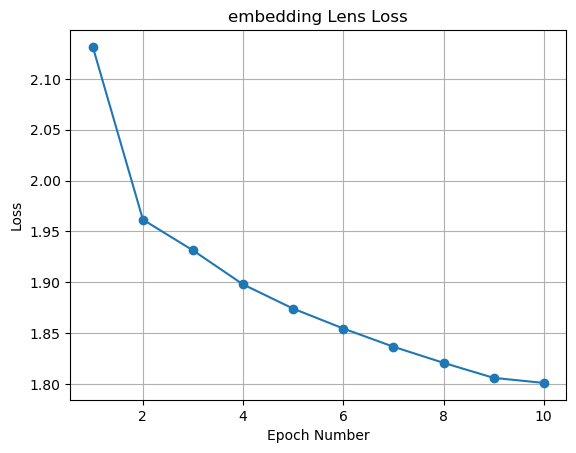

In [19]:
# Training
embedding_lens_losses = embedding_lens.train_model(train_dataloader=embedding_train_loader,
                                                   criterion=kl_loss_teacher_student,
                                                   optimizer=embedding_lens_optimizer,
                                                   num_epochs=num_epochs,
                                                   device=device,
                                                   proj_dir=proj_dir,
                                                   sub_model=embedding_model,
                                                   final_model=model,
                                                   pad_token_id=pad_idx,
                                                   scheduler=embedding_lens_scheduler)

In [20]:
# Evaluation
embedding_lens.evaluate_model(test_dataloader=embedding_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=embedding_model,
                              final_model=model,
                              pad_token_id=pad_idx)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Eval embedding lens: 100%|██████████| 1375/1375 [00:34<00:00, 39.29it/s]


Eval embedding Lens - Avg loss: 1.883532, Accuracy vs teacher (last pos): 0.3461


{'avg_val_loss': 1.8835321900713613, 'accuracy': 0.34612586395052747}

### Attention Lens

In [21]:
## Preparing for training the attention lens

# Clearing cache to prepare for training
torch.cuda.empty_cache()

# Hyperparameters
batch_size = 4
num_epochs = 10

# Attention model
attention_model = AttentionModel(model).to(device)

# Dataset + DataLoader that returns batches of token ids
attention_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=2, pin_memory=True)

attention_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn,
                         num_workers=2, pin_memory=True)

# instantiate embedding lens
attention_lens = TunedLens(d_model = d_model,
                           last_norm = model.transformer.ln_f,
                           unembedding_layer = model.lm_head,
                           name='attention',
                           bias_only = False).to(device)

# optimizer & scheduler
attention_lens_optimizer = optim.Adam(attention_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch)
attention_lens_scheduler = OneCycleLR(attention_lens_optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(attention_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/10: 100%|██████████| 4123/4123 [02:12<00:00, 31.12it/s]


Epoch [1/10]  Avg Loss: 0.967190  LR: 0.00280035


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.36it/s]


Epoch [2/10]  Avg Loss: 0.707893  LR: 0.0076007


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
TOKENIZERS_PARALLELISM=(true | false)iable 
Epoch 3/10: 100%|██████████| 4123/4123 [02:12<00:00, 31.15it/s]


Epoch [3/10]  Avg Loss: 0.665153  LR: 0.01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 4/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.26it/s]


Epoch [4/10]  Avg Loss: 0.618654  LR: 0.00950461


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 5/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.32it/s]


Epoch [5/10]  Avg Loss: 0.579158  LR: 0.00811703


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 6/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.25it/s]


Epoch [6/10]  Avg Loss: 0.547603  LR: 0.00611209


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 7/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.30it/s]


Epoch [7/10]  Avg Loss: 0.522829  LR: 0.00388689


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 8/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.30it/s]


Epoch [8/10]  Avg Loss: 0.501874  LR: 0.00188216


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 9/10: 100%|██████████| 4123/4123 [02:11<00:00, 31.30it/s]


Epoch [9/10]  Avg Loss: 0.485788  LR: 0.000494958


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 10/10: 100%|██████████| 4123/4123 [02:12<00:00, 31.21it/s]


Epoch [10/10]  Avg Loss: 0.477364  LR: 4.00296e-08
Checkpoint for Epoch 10 saved to QLens/attention_lens_checkpoint.pth


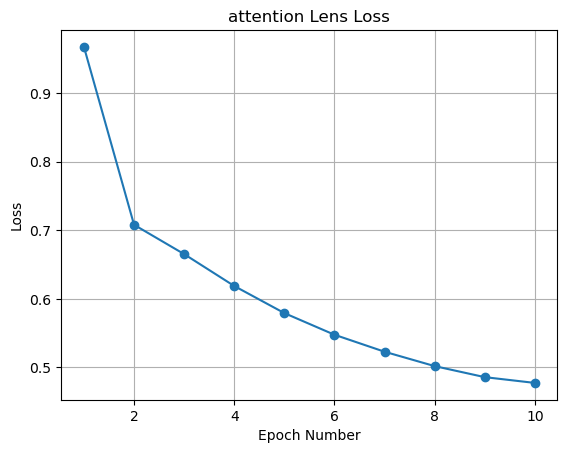

In [22]:
attention_lens_losses = attention_lens.train_model(train_dataloader=attention_train_loader,
                                                   criterion=kl_loss_teacher_student,
                                                   optimizer=attention_lens_optimizer,
                                                   num_epochs=num_epochs,
                                                   device=device,
                                                   proj_dir=proj_dir,
                                                   sub_model=attention_model,
                                                   final_model=model,
                                                   pad_token_id=pad_idx,
                                                   scheduler=attention_lens_scheduler)

In [23]:
attention_lens.evaluate_model(test_dataloader=attention_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=attention_model,
                              final_model=model,
                              pad_token_id=pad_idx)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Eval attention lens: 100%|██████████| 1375/1375 [00:36<00:00, 37.41it/s]


Eval attention Lens - Avg loss: 0.556310, Accuracy vs teacher (last pos): 0.6475


{'avg_val_loss': 0.5563095188674254, 'accuracy': 0.6475081847944707}